In [3]:
# Chhavi Sharma – ShieldHer Voice Stress Detection
# STEP 1: Install Libraries

!pip install librosa tensorflow scikit-learn --quiet
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models


In [7]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/Audio_Speech_Actors_01-24.zip"
extract_path = "/content/ravdess_audio"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Files extracted to:", extract_path)


✅ Files extracted to: /content/ravdess_audio


In [9]:
import librosa
import numpy as np
import os

data_path = "/content/ravdess_audio"
X = []  # Features
y = []  # Labels

# Define emotion map from filename (RAVDESS format)
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def extract_emotion(filename):
    parts = filename.split("-")
    emotion_code = parts[2]
    return emotion_map.get(emotion_code)

# Loop through audio files
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            try:
                audio, sr = librosa.load(file_path, sr=22050)
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
                mfcc_scaled = np.mean(mfcc.T, axis=0)
                emotion = extract_emotion(file)
                if emotion in ["angry", "fearful", "sad"]:  # Stress emotions
                    X.append(mfcc_scaled)
                    y.append(1)  # Stressed
                elif emotion in ["calm", "happy", "neutral"]:
                    X.append(mfcc_scaled)
                    y.append(0)  # Not stressed
            except Exception as e:
                print("Error processing", file_path)

print(f"✅ Extracted features: {len(X)} samples")


✅ Extracted features: 1056 samples


In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert lists to arrays
X = np.array(X)
y = np.array(y)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = Sequential()
model.add(Dense(256, input_shape=(40,), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4731 - loss: 14.9419 - val_accuracy: 0.5094 - val_loss: 4.7560
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5335 - loss: 7.2556 - val_accuracy: 0.5094 - val_loss: 1.5785
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5280 - loss: 4.4560 - val_accuracy: 0.5660 - val_loss: 0.7511
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5950 - loss: 2.4585 - val_accuracy: 0.5472 - val_loss: 0.7315
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5362 - loss: 1.6082 - val_accuracy: 0.5849 - val_loss: 0.6817
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5288 - loss: 1.1270 - val_accuracy: 0.5094 - val_loss: 0.6913
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5437 - loss: 0.9252 - val_accuracy: 0.5094 - val_loss: 0.6915
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5329 - loss: 0.7878 - val_accuracy: 0.5094 - val_los

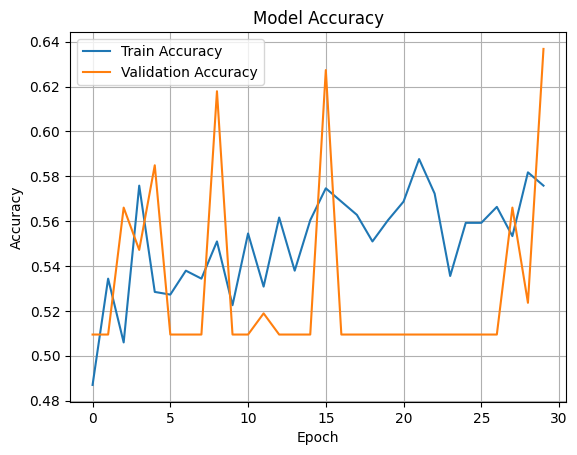

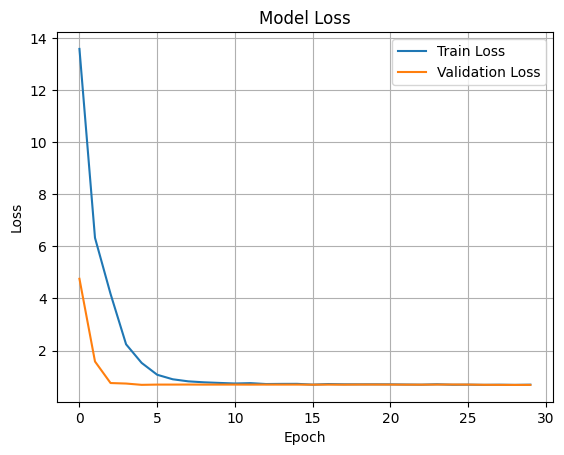

In [11]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6071 - loss: 0.6799 
Test Accuracy: 63.68%


In [13]:
# Save as H5
model.save("voice_stress_model.h5")

# Convert to TFLite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite file
with open("voice_stress_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved successfully.")


Saved artifact at '/tmp/tmpshrs54nw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139257628204432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257815328784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257628206544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257631109968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257631104208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257631103632: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ TFLite model saved successfully.


In [14]:
model.save("voice_stress_model.h5")


In [15]:
from google.colab import files
files.download("voice_stress_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("voice_stress_model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpmdt7vakx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139257628204432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257815328784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257628206544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257631109968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257631104208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139257631103632: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [17]:
files.download("voice_stress_model.tflite")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>